In [1]:
//Dependency stuff
@file:Repository("https://repo1.maven.org/maven2")
@file:DependsOn("com.github.holgerbrandl:krangl:0.18")
@file:DependsOn("com.github.holgerbrandl:kravis:0.8.5")
@file:DependsOn("thu.mohr.jonas:PhysicsExperimentLib:3.0.0")
@file:DependsOn("org.apache.commons:commons-lang3:3.12.0")
//Import custom library
import thu.mohr.jonas.physics.*

In [2]:
//Read raw Phyphox data, throwing out all "boring" data
val rawData = DataFrame.readCSV("RawData.csv")

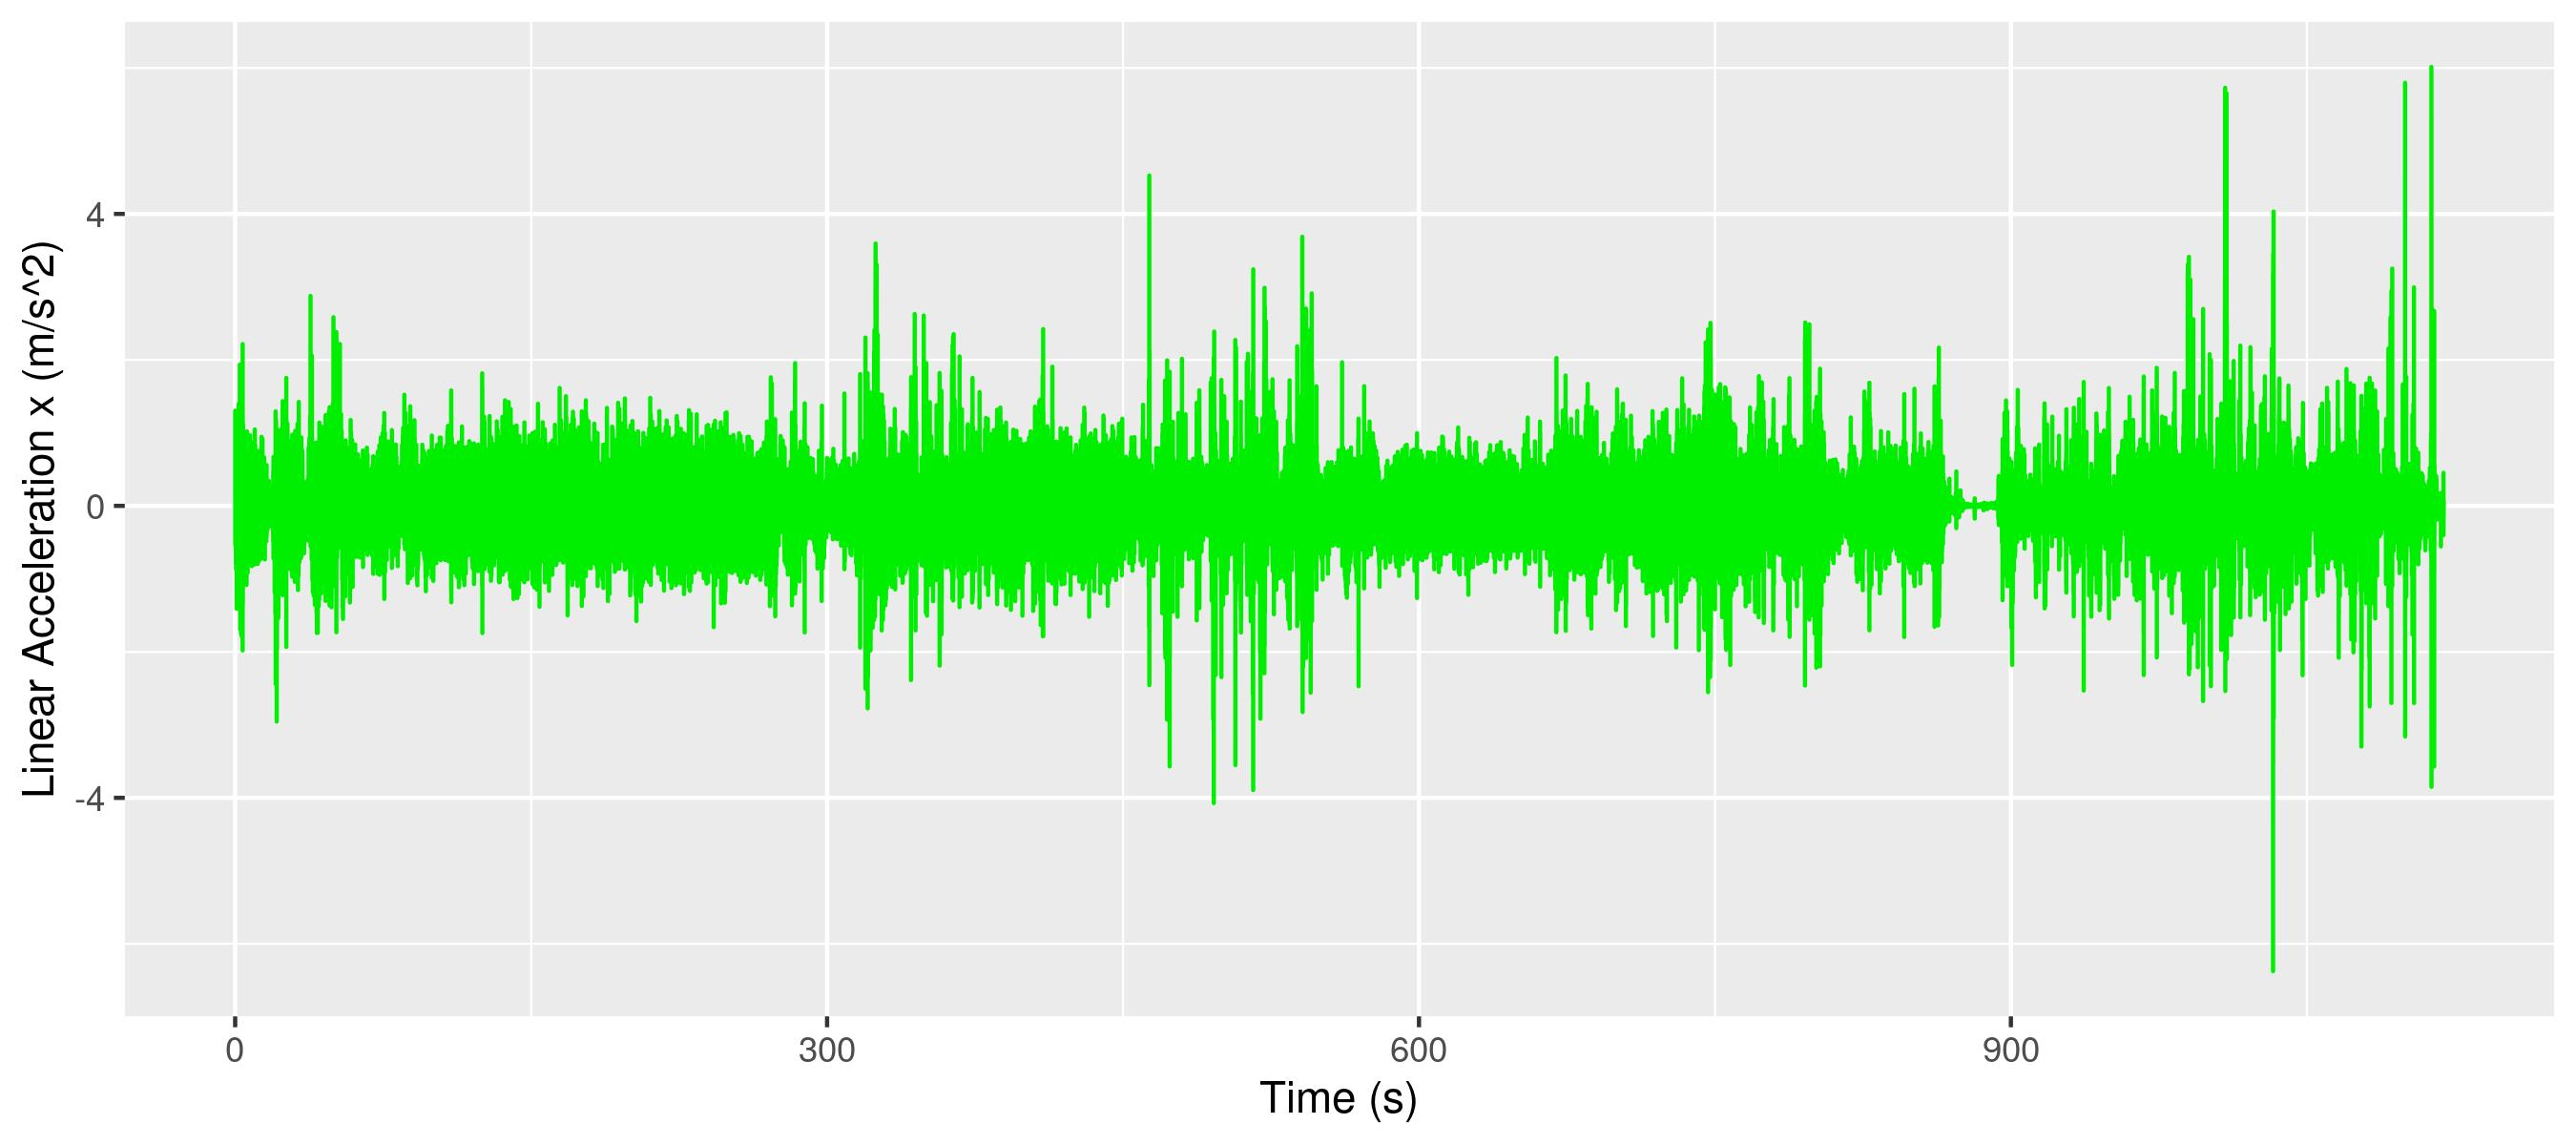

In [3]:
//Plot raw x-axis data
rawData.plot(Aes(x = "Time (s)")).geomLine(color = RColor.green2, mapping = Aes(y="Linear Acceleration x (m/s^2)"))

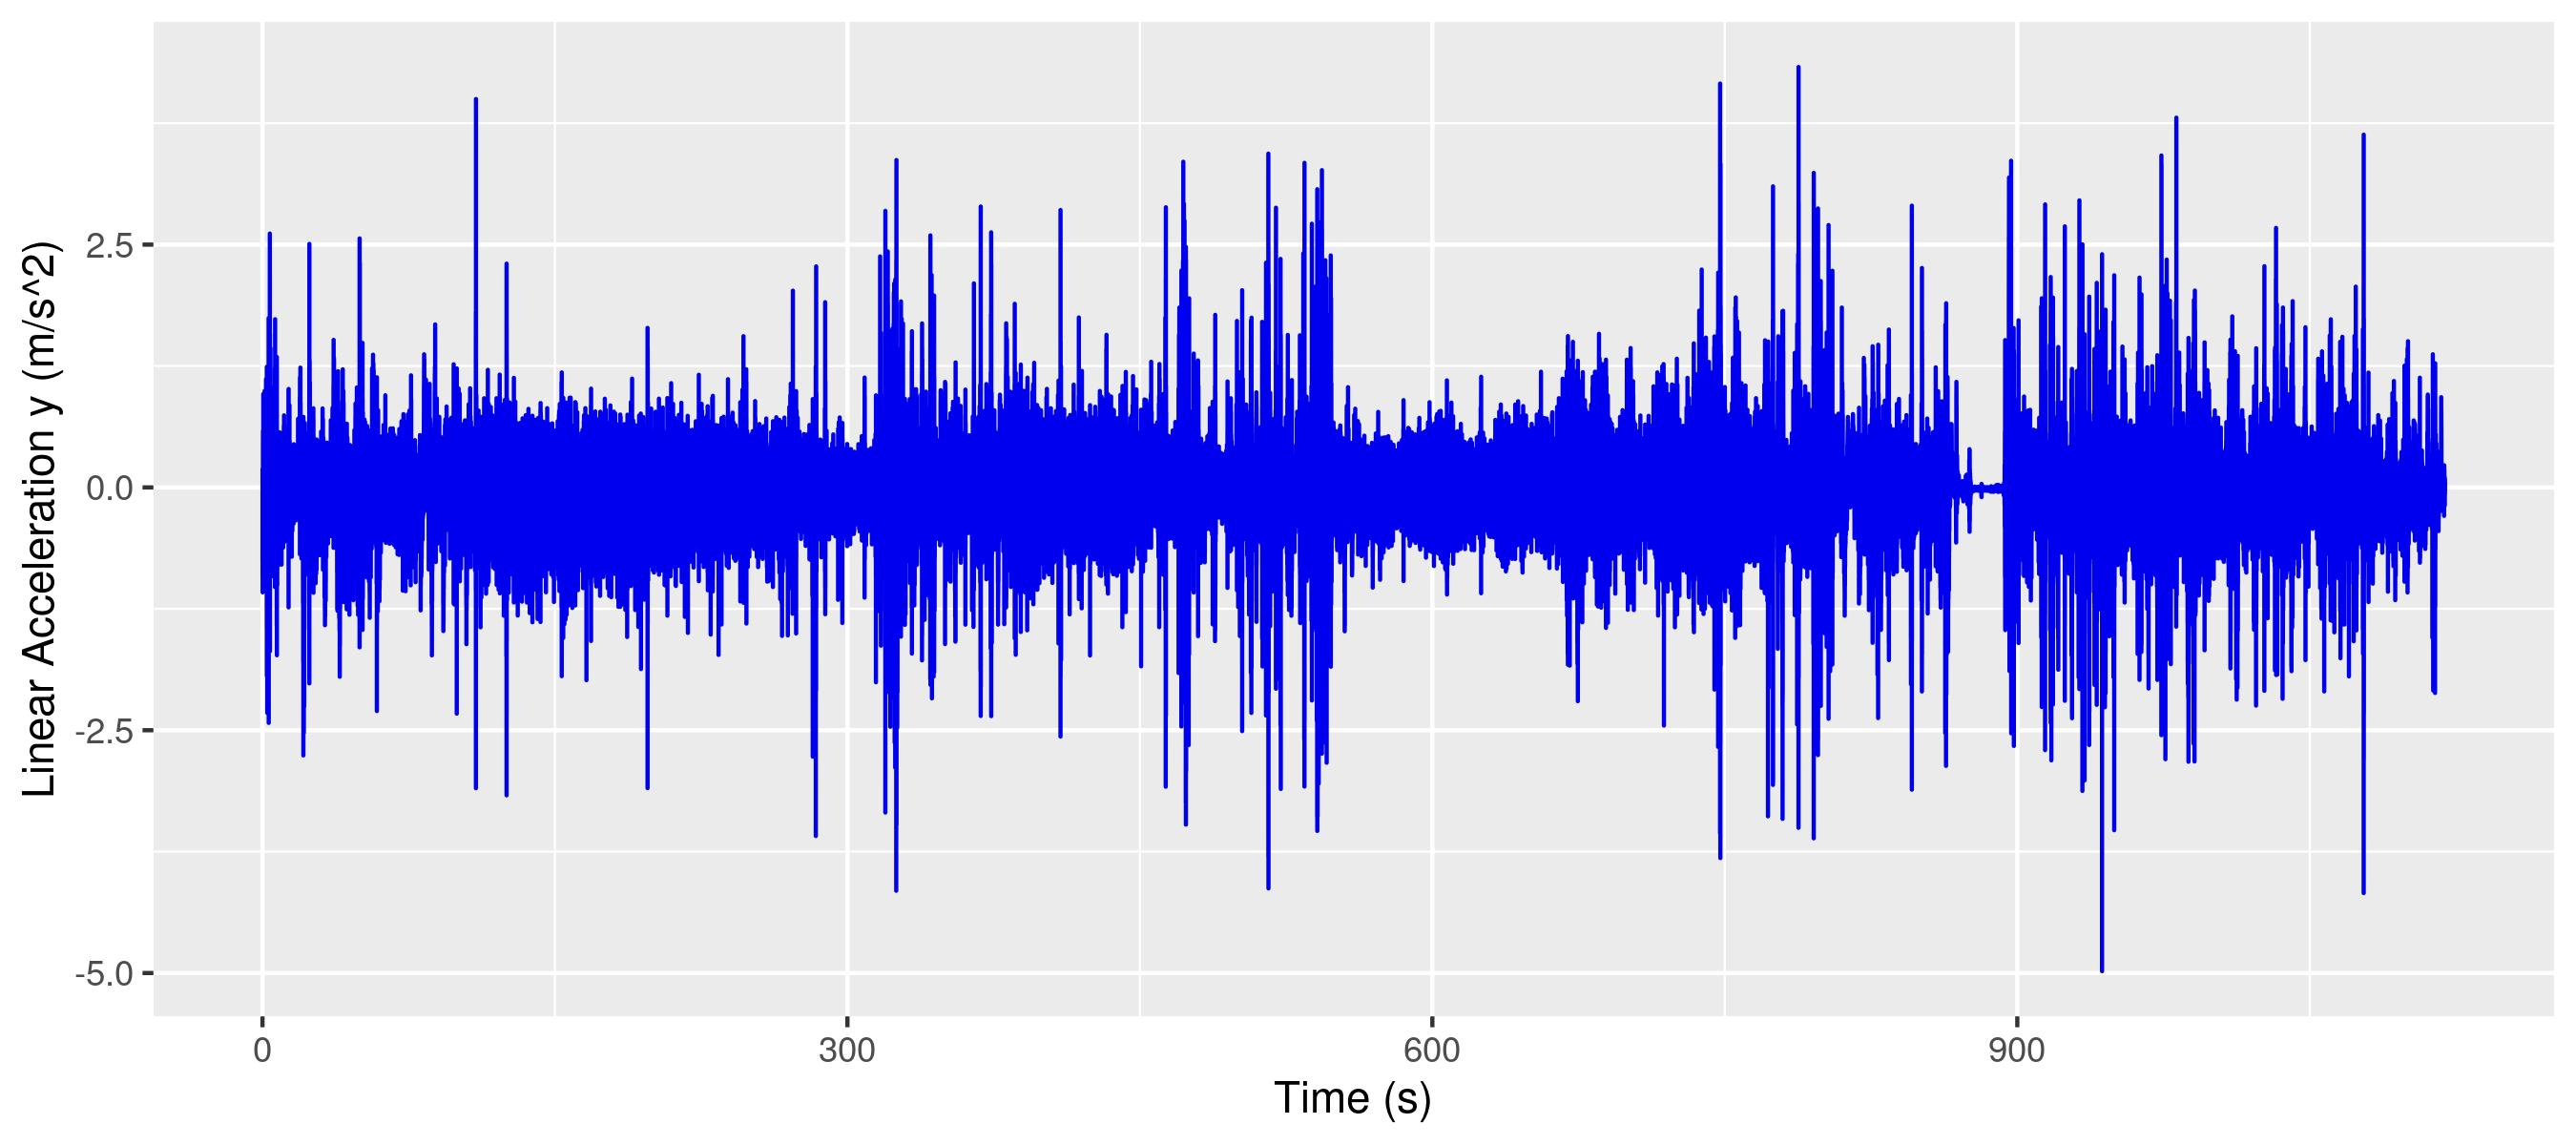

In [4]:
//Plot raw y-axis data
rawData.plot(Aes(x = "Time (s)")).geomLine(color = RColor.blue2, mapping = Aes(y="Linear Acceleration y (m/s^2)"))

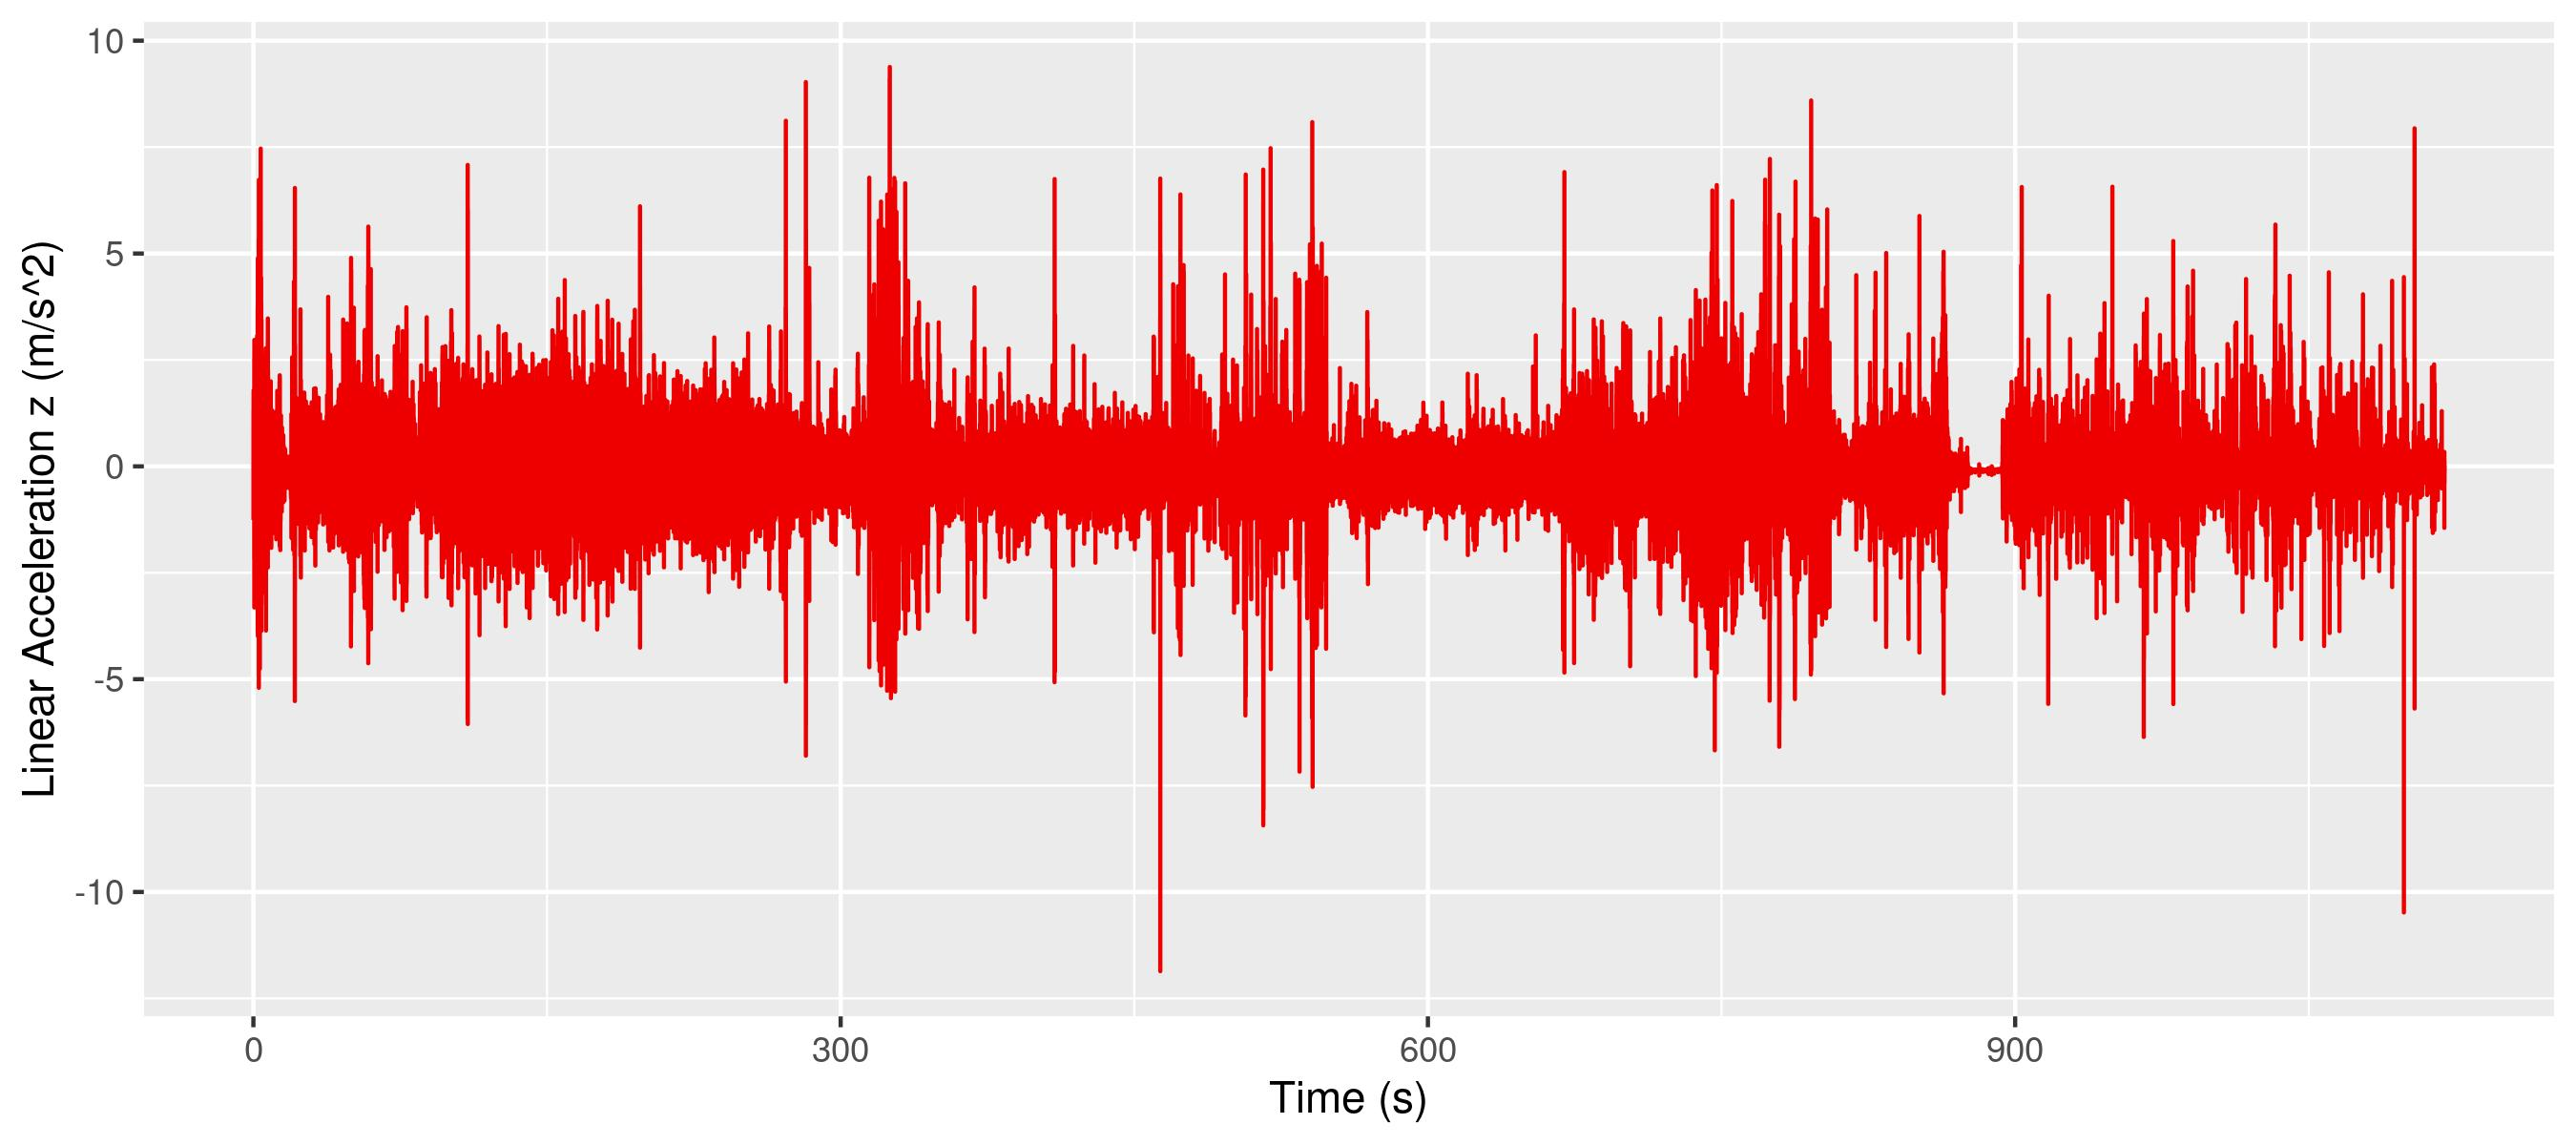

In [5]:
//Plot raw z-axis data
//In this experiment, the z-axis data is quite useless
rawData.plot(Aes(x = "Time (s)")).geomLine(color = RColor.red2, mapping = Aes(y="Linear Acceleration z (m/s^2)"))

In [6]:
//A simple test pattern to find in the data: 2 to ∞ adjacent data-points with a rise of 1.0 to ∞ g's each
val testPattern = ValuePattern(ValuePatternPart(ValueRelationType.ASCENDING, 2, Int.MAX_VALUE, 0.5, Double.MAX_VALUE))

In [7]:
fun applyPattern(pattern: ValuePattern, frame: DataFrame, colName: String): DataFrame {
    //Map chunks of size 2 to ValueRelations
    val valueRelations = frame.rows.chunked(2)
    //An uneven amount of data-points causes one half-empty chunk, filtering it out
    .filter{chunk -> chunk.size == 2}
    .map { valueChunk -> ValueRelation(valueChunk[0][colName] as Double, 
                                       valueChunk[1][colName] as Double,
                                       valueChunk[0]["Time (s)"] as Double, 
                                       valueChunk[1]["Time (s)"] as Double)}
    .toMutableList()
    val results = emptyList<List<ValueRelation>>().toMutableList()
    for(start in 0 until valueRelations.size - pattern.patternParts.sumOf{part -> part.nmin} - 1) {
        var i = (start + pattern.patternParts.sumOf{part -> part.nmin}).coerceAtMost(valueRelations.size -1)
        if(!pattern.matches(valueRelations.slice(start until i))) continue
        while(pattern.matches(valueRelations.slice(start until i)) && i != valueRelations.size - 1) {
            i++
        }
        results.add(valueRelations.slice(start until i))
        valueRelations.removeAll(valueRelations.slice(start until i))
    }
    //println(results.size)
    //results.forEach{result -> println(StringUtils.repeat("=", 50)); result.forEach{value -> println(ReflectionToStringBuilder.toString(value)); println(StringUtils.repeat("=", 50))}}
    //val filteredRelations = valueRelations.slice(applyPattern(
    val mappedTimes = results.map{relations -> relations[relations.size / 2] }.map{relation -> relation.firstValueTime!!}
    return rawData.filterByRow { mappedTimes.contains(it["Time (s)"] as Double) }
    //return frame
}
//applyPattern(ValuePattern(ValuePatternPart(ValueRelationType.ASCENDING, 1, Int.MAX_VALUE, 0.1, Double.MAX_VALUE), ValuePatternPart(ValueRelationType.DESCENDING, 1, Int.MAX_VALUE, 0.1, Double.MAX_VALUE)), rawData, "Linear Acceleration y (m/s^2)")

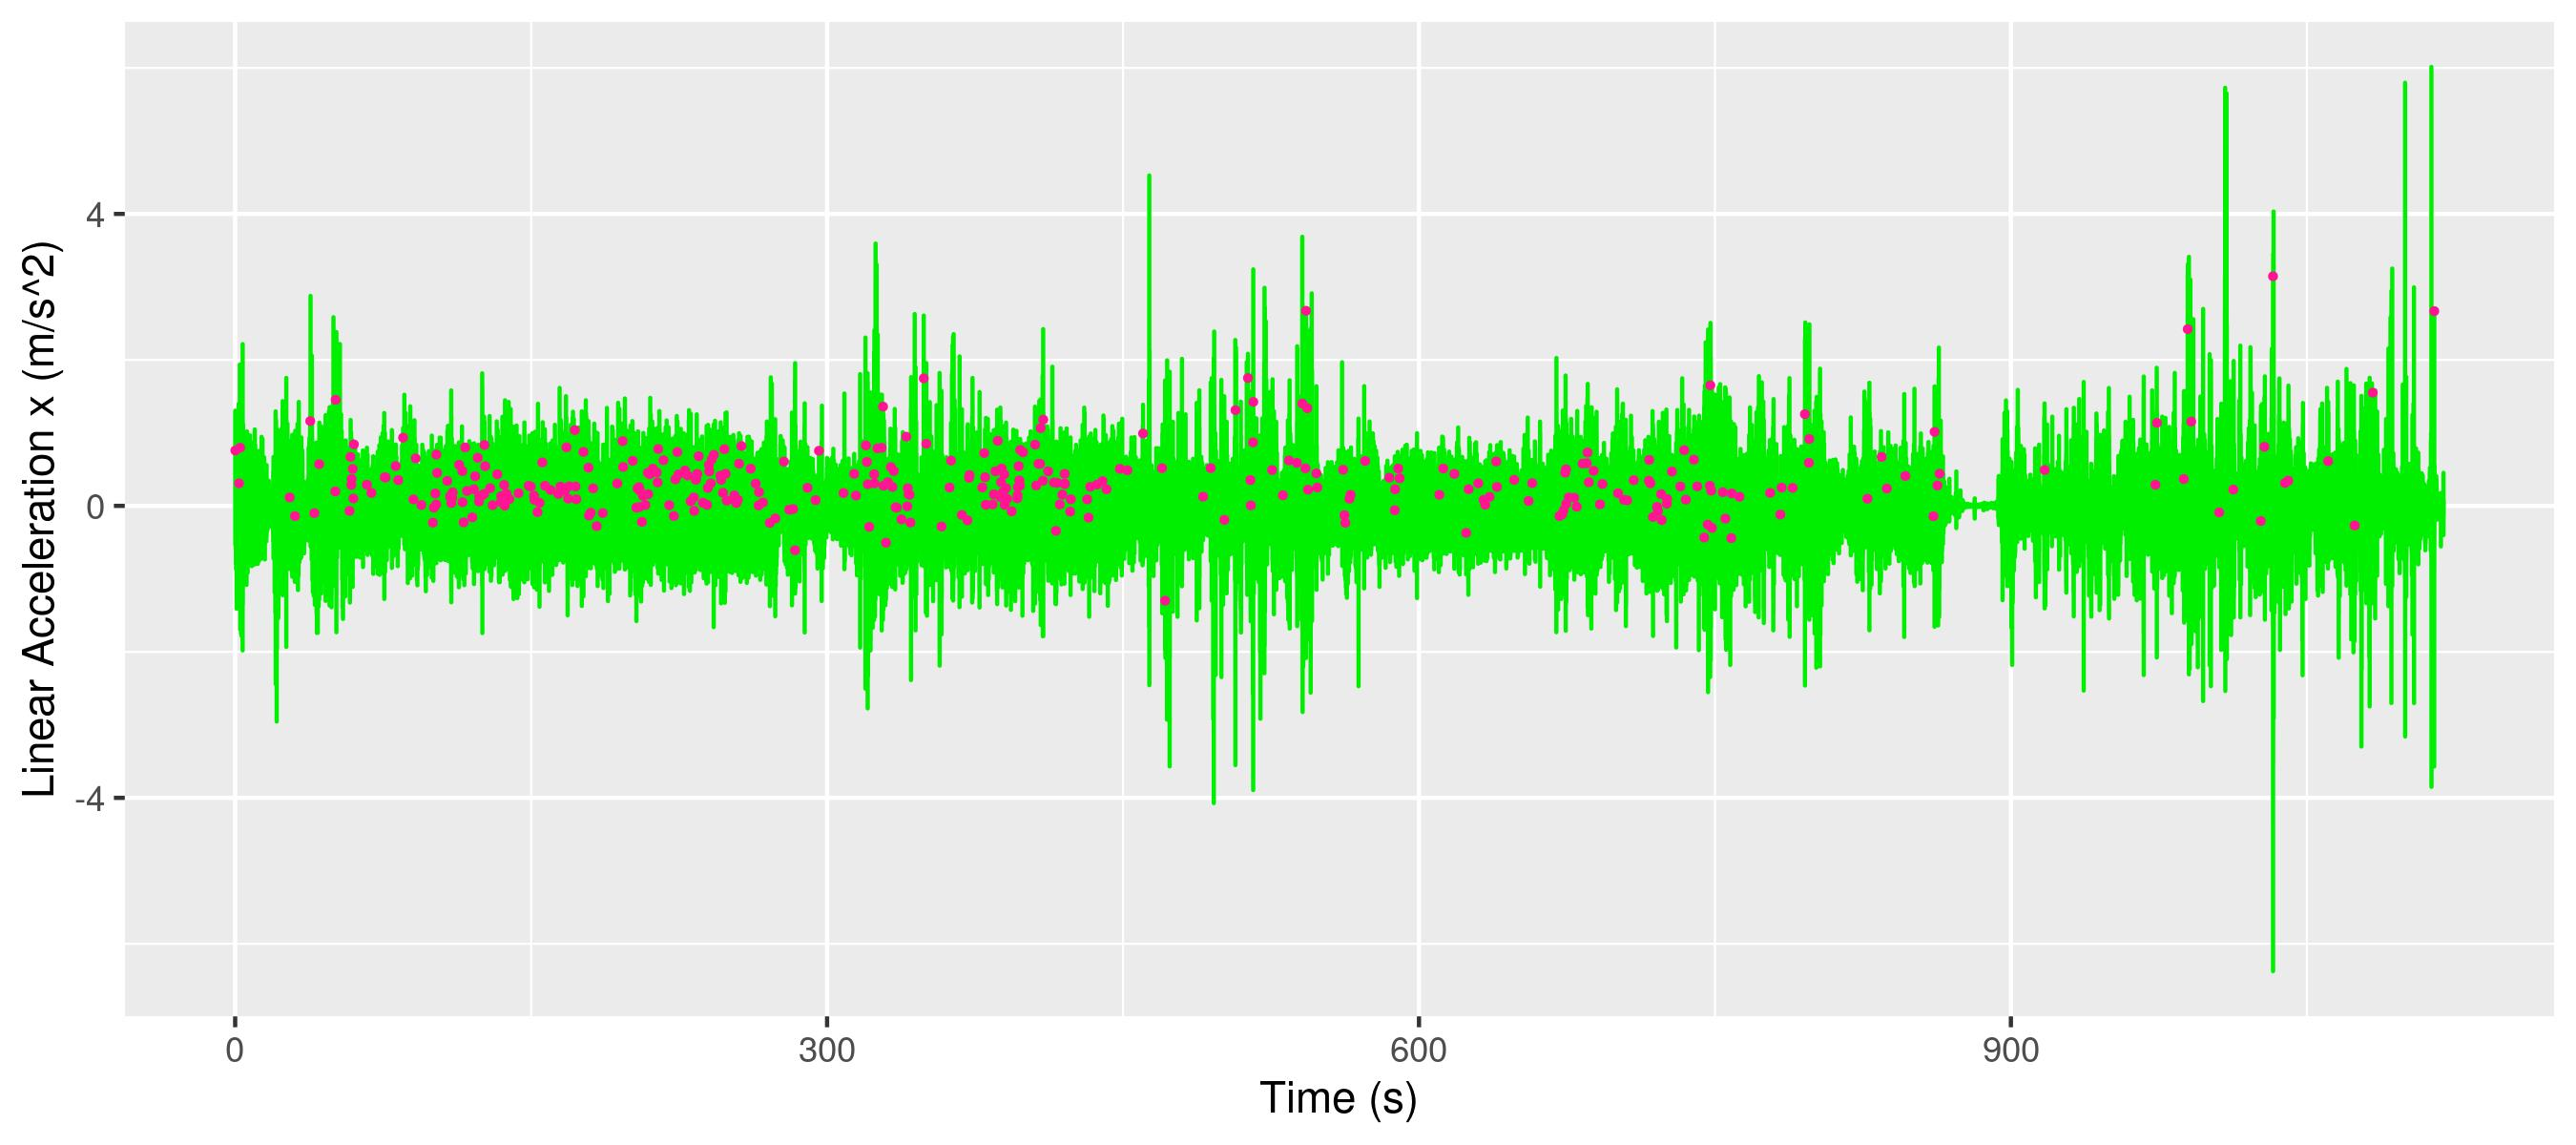

In [8]:
//Plot the raw data as well as the filtered data
val turnPattern = ValuePattern(
    ValuePatternPart(ValueRelationType.ASCENDING, 2, Int.MAX_VALUE, 0.3, Double.MAX_VALUE),
    ValuePatternPart(ValueRelationType.EQUAL, 0, Int.MAX_VALUE, 0.0, Double.MAX_VALUE),
    ValuePatternPart(ValueRelationType.DESCENDING, 2, Int.MAX_VALUE, 0.3, Double.MAX_VALUE)
)

val filteredXData = applyPattern(turnPattern, rawData, "Linear Acceleration x (m/s^2)")
rawData.plot(Aes(x = "Time (s)"))
    .geomLine(color = RColor.green2, mapping = Aes(y="Linear Acceleration x (m/s^2)"))
    .geomPoint(color = RColor.deeppink, mapping = Aes(y="Linear Acceleration x (m/s^2)"), `data` = filteredXData, size = 0.5)

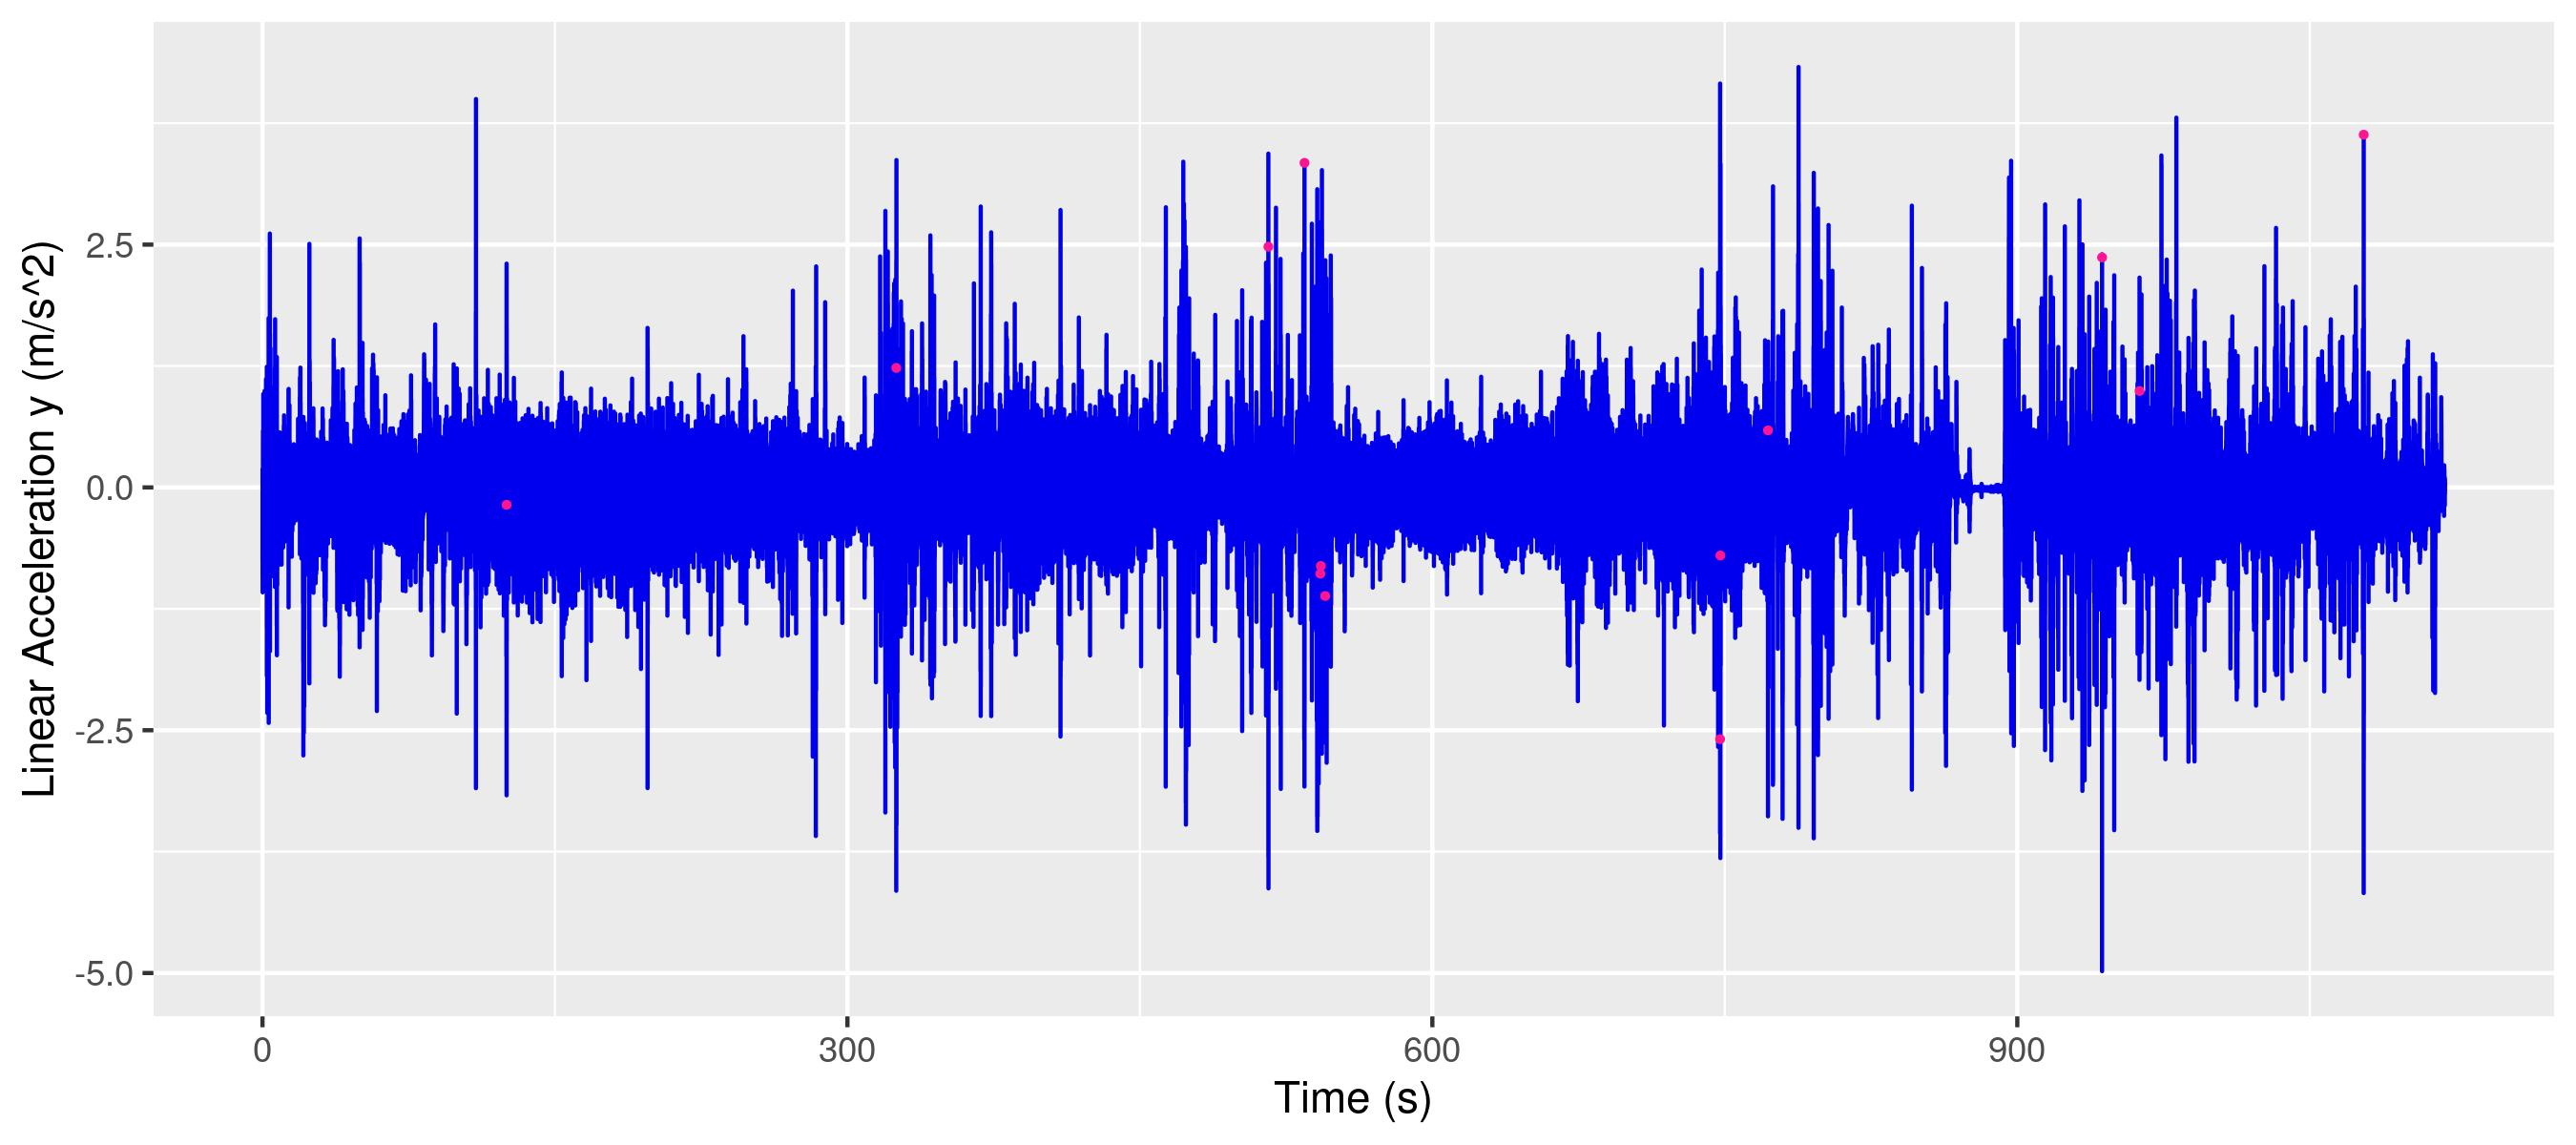

In [9]:
//Look for turn Patterns in the raw data
val highAccelPattern = ValuePattern(
    ValuePatternPart(ValueRelationType.ASCENDING, 1, 1, 4.0, Double.MAX_VALUE)
)
val filteredYData = applyPattern(highAccelPattern, rawData, "Linear Acceleration y (m/s^2)")
//println(filteredXData.nrow)
rawData.plot(Aes(x = "Time (s)"))
    .geomLine(color = RColor.blue2, mapping = Aes(y="Linear Acceleration y (m/s^2)"))
    .geomPoint(color = RColor.deeppink, mapping = Aes(y="Linear Acceleration y (m/s^2)"), `data` = filteredYData, size = 0.5)